# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.layers import Embedding
from keras.preprocessing.text import tokenizer_from_json

from keras.callbacks import EarlyStopping

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
# https://www.kaggle.com/code/danofer/deep-protein-sequence-family-classification/notebook

# Load Data

In [3]:
data = pd.read_csv("protein_class_prep/pdb_data_no_dups.csv")

In [4]:
sequnce = pd.read_csv("protein_class_prep/pdb_data_seq.csv")

# Data Preprocessing

In [5]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [6]:
sequnce.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [7]:
# the same columns in both datasets
sequnce.drop(columns=['residueCount', 'macromoleculeType'], inplace=True)

In [8]:
df = data.merge(sequnce, how='inner', on='structureId')

In [9]:
# Drop rows with missing labels
df = df[[type(c) == type('') for c in df.classification.values]]
df = df[[type(c) == type('') for c in df.sequence.values]]

# select proteins
df = df[df.macromoleculeType == 'Protein']
df.reset_index()
print(df.shape)
df.head()

(346321, 16)


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


remove some longer/shorter sequences

In [10]:
print(df.residueCount.quantile(0.9))
df.residueCount.describe()

5628.0


count    346321.000000
mean       4708.585243
std       26484.309151
min           3.000000
25%         398.000000
50%         856.000000
75%        1976.000000
max      313236.000000
Name: residueCount, dtype: float64

In [11]:
df = df.loc[df.residueCount<1200]
print(df.shape[0])
df.residueCount.describe()

212258


count    212258.000000
mean        529.197415
std         305.092634
min           3.000000
25%         280.000000
50%         485.000000
75%         768.000000
max        1198.000000
Name: residueCount, dtype: float64

Only 10 most common classes are considered - because computational limitations

at least 4015 instances per class
212258 instances before
111166 instances after


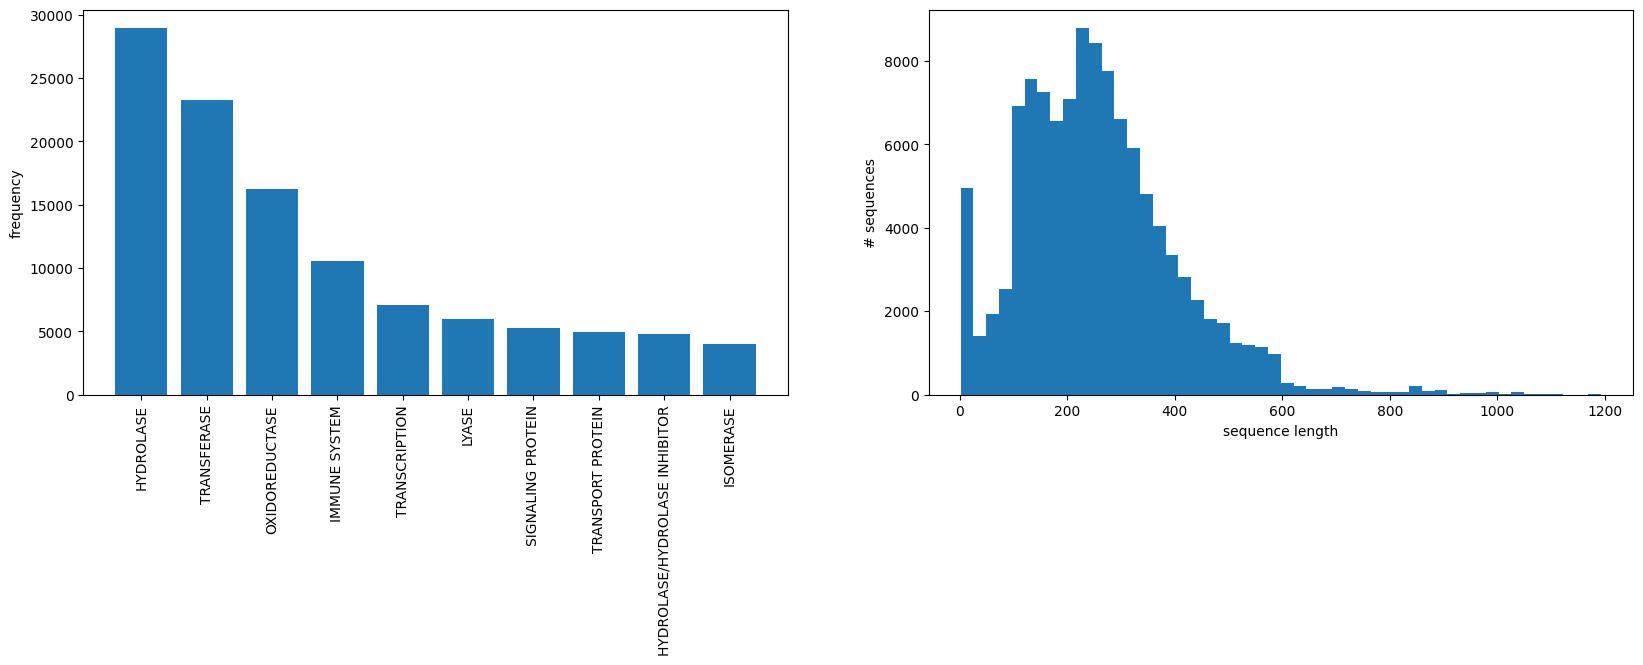

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

# count numbers of instances per class
cnt = Counter(df.classification)
# select only K most common classes! - was 10 by default
top_classes = 10
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

# apply to dataframe
print(str(df.shape[0]) + " instances before")
df = df[[c in classes for c in df.classification]]
print(str(df.shape[0]) + " instances after")

seqs = df.sequence.values
lengths = [len(s) for s in seqs]

# visualize
fig, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].bar(range(len(classes)), counts)
plt.sca(axarr[0])
plt.xticks(range(len(classes)), classes, rotation='vertical')
axarr[0].set_ylabel('frequency')

axarr[1].hist(lengths, bins=50)
axarr[1].set_xlabel('sequence length')
axarr[1].set_ylabel('# sequences')
plt.show()

#### Transform labels

In [15]:
# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(df.classification)

In [16]:
# maximum length of sequence, everything afterwards is discarded! Default 256
max_length = 350

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

#### Split data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, shuffle=True, random_state=42)

# Create the model

In [18]:
embedding_dim = 25

# create the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu',dilation_rate=1))
# model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu')) #orig
model.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu',dilation_rate=1))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
model.add(AveragePooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) # orig
model.add(Conv1D(filters=128, kernel_size=7, padding='valid', activation='relu',dilation_rate=2)) 
model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
model.add(AveragePooling1D(pool_size=2))

# model.add(Flatten()) ## Could do pooling instead 
# GlobalAveragePooling1D,GlobalMaxPooling1D
model.add(GlobalAveragePooling1D())

model.add(Dense(256, activation='relu')) # 128
model.add(BatchNormalization())
model.add(Dense(128, activation='relu')) # 128
model.add(BatchNormalization())
model.add(Dense(top_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 25)           650       
                                                                 
 conv1d (Conv1D)             (None, 350, 128)          12928     
                                                                 
 conv1d_1 (Conv1D)           (None, 346, 128)          82048     
                                                                 
 average_pooling1d (Average  (None, 173, 128)          0         
 Pooling1D)                                                      
                                                                 
 conv1d_2 (Conv1D)           (None, 161, 128)          114816    
                                                                 
 batch_normalization (Batch  (None, 161, 128)          512       
 Normalization)                                         

In [19]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)

history = model.fit(X_train, y_train,  batch_size=128, verbose=1, validation_split=0.15,callbacks=[es],epochs=25) # epochs=15, # batch_size=128

Epoch 1/25
591/591 [==============================] - 251s 422ms/step - loss: 1.4857 - accuracy: 0.4914 - val_loss: 1.8317 - val_accuracy: 0.3309
Epoch 2/25
591/591 [==============================] - 322s 545ms/step - loss: 1.0179 - accuracy: 0.6655 - val_loss: 4.0907 - val_accuracy: 0.2266
Epoch 3/25
591/591 [==============================] - 482s 815ms/step - loss: 0.7547 - accuracy: 0.7586 - val_loss: 2.2016 - val_accuracy: 0.3639
Epoch 4/25
591/591 [==============================] - 473s 801ms/step - loss: 0.5990 - accuracy: 0.8093 - val_loss: 2.6563 - val_accuracy: 0.3773
Epoch 5/25
591/591 [==============================] - 454s 769ms/step - loss: 0.4965 - accuracy: 0.8421 - val_loss: 1.0722 - val_accuracy: 0.6786
Epoch 6/25
591/591 [==============================] - 214s 362ms/step - loss: 0.4306 - accuracy: 0.8616 - val_loss: 2.2388 - val_accuracy: 0.5373
Epoch 7/25
591/591 [==============================] - 215s 365ms/step - loss: 0.3824 - accuracy: 0.8770 - val_loss: 2.5639 -

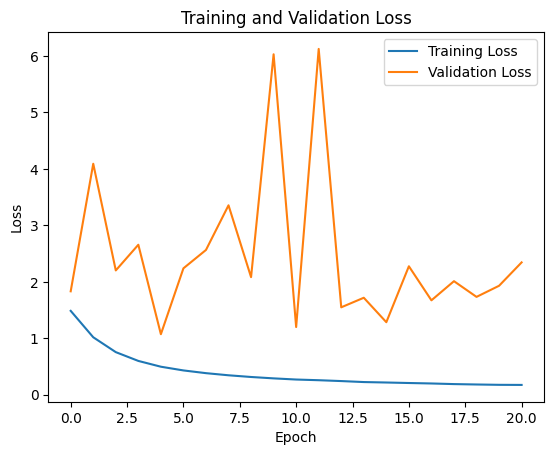

In [20]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


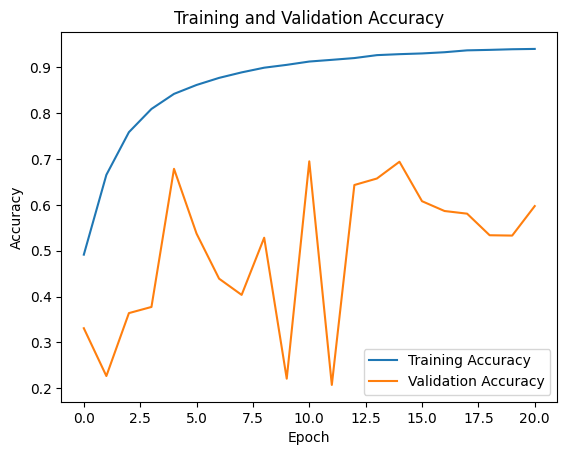

In [21]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

695/695 [==============================] - 25s 36ms/step


In [23]:
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

train-acc = 0.6227454684478028
test-acc = 0.5949446793199604


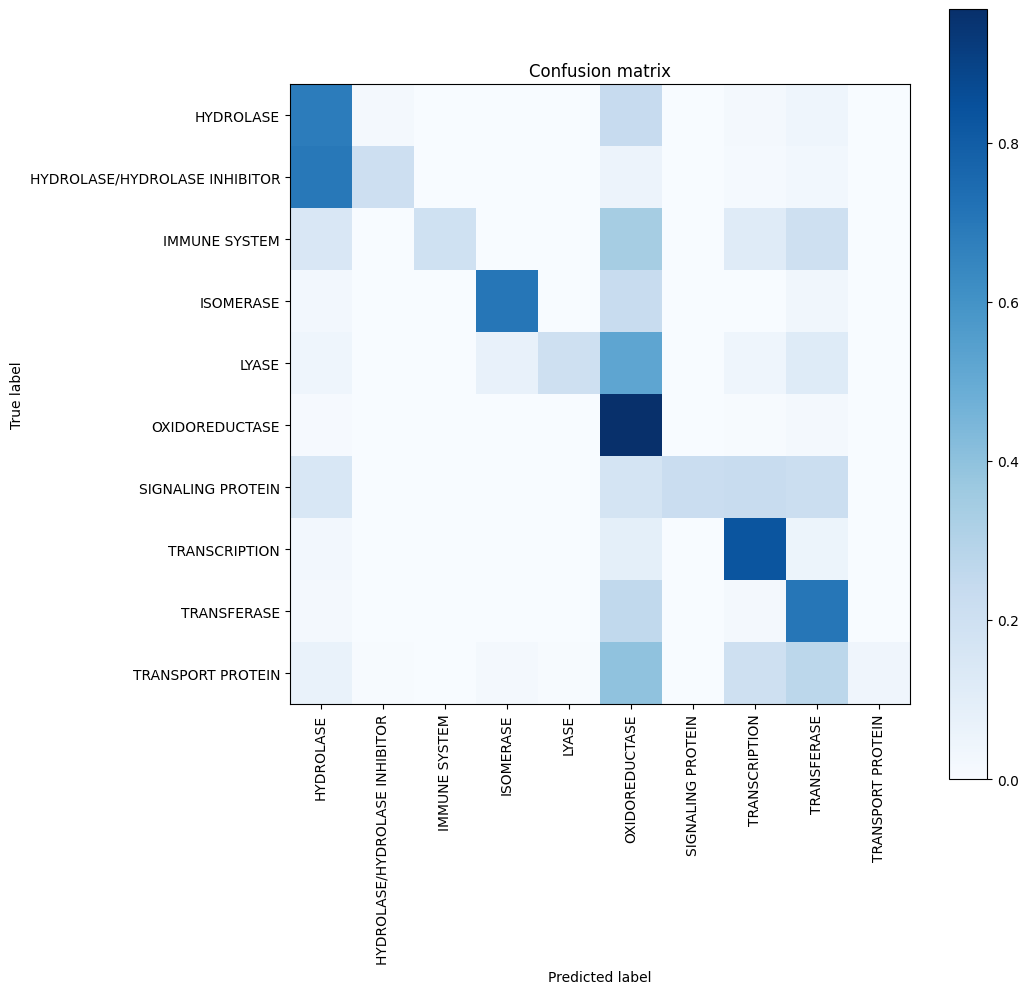

                               precision    recall  f1-score   support

                    HYDROLASE       0.73      0.68      0.71      5762
HYDROLASE/HYDROLASE INHIBITOR       0.66      0.20      0.31       961
                IMMUNE SYSTEM       0.99      0.20      0.33      2118
                    ISOMERASE       0.80      0.70      0.75       799
                        LYASE       0.98      0.20      0.33      1199
               OXIDOREDUCTASE       0.40      0.97      0.56      3274
            SIGNALING PROTEIN       0.94      0.22      0.36      1078
                TRANSCRIPTION       0.55      0.83      0.66      1423
                  TRANSFERASE       0.68      0.70      0.69      4598
            TRANSPORT PROTEIN       1.00      0.04      0.07      1022

                     accuracy                           0.59     22234
                    macro avg       0.77      0.48      0.48     22234
                 weighted avg       0.72      0.59      0.56     22234


In [24]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

# Save the model and tokenizer

In [25]:
model.save('trained_model/protein_classification.keras')

In [26]:
tokenizer_json = tokenizer.to_json()
with open('trained_model/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

# Test example

In [27]:
# Load model
model_loaded = load_model('trained_model/protein_classification.keras')

In [28]:
with open('trained_model/tokenizer.json', 'r', encoding='utf-8') as f:
    loaded_tokenizer_json = f.read()
    loaded_tokenizer = tokenizer_from_json(loaded_tokenizer_json)

In [38]:
protein_string = 'SLCGLKKECLIA' 

In [39]:
max_length = 350

test_protein = loaded_tokenizer.texts_to_sequences([protein_string])
test_protein = sequence.pad_sequences(test_protein, maxlen=max_length)
test_protein

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [40]:
predicted_protein = model_loaded.predict(test_protein)

1/1 [==============================] - 0s 19ms/step


In [41]:
predicted_protein = pd.DataFrame(predicted_protein)

In [42]:
col_names = ['HYDROLASE',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'IMMUNE SYSTEM',
 'ISOMERASE',
 'LYASE',
 'OXIDOREDUCTASE',
 'SIGNALING PROTEIN',
 'TRANSCRIPTION',
 'TRANSFERASE',
 'TRANSPORT PROTEIN']

In [43]:
predicted_protein.columns = col_names

In [44]:
predicted_protein

,HYDROLASE,HYDROLASE/HYDROLASE INHIBITOR,IMMUNE SYSTEM,ISOMERASE,LYASE,OXIDOREDUCTASE,SIGNALING PROTEIN,TRANSCRIPTION,TRANSFERASE,TRANSPORT PROTEIN
0,0.742412,0.000127,0.000016,0.000007,8.463628e-07,9.571468e-07,0.000756,0.254375,0.002305,5.147641e-09


In [45]:
predicted_class = predicted_protein.max().idxmax()

In [46]:
predicted_class

'HYDROLASE'